# Notebook: Create Wordcloud Analysis 

This notebook is used to create wordclouds using our trained model.
<br>**Contributors:** [Nils Hellwig](https://github.com/NilsHellwig/) | [Markus Bink](https://github.com/MarkusBink/)

## Packages

In [1]:
from reportlab.graphics import renderPDF
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from svglib.svglib import svg2rlg
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import nltk
import re
import os

## Parameters

In [2]:
PLOTS_PATH = "../Plots/"
PARTIES = ["SPD", "CDU_CSU", "GRUENE", "FDP", "AFD", "LINKE"]
DATASET_PATH_PREDICTIONS =  "../Datasets/complete_dataset_predictions/"
DATASET_PATH = "../Datasets/dataset/"
WORD_CLOUDS_PATH = "../Plots/wordclouds/"
FONT_PATH = 'fonts/manrope-regular.otf'

## Setup Packags

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("german"))
STOPWORDS.update(["mehr", "heute","https", "bundestag", "thread", "anzeigen"])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nils_hellwig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nils_hellwig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Code

### 1. Load Data

In [4]:
df = pd.DataFrame({})

for party in PARTIES:
    for subdir, _, files in os.walk(DATASET_PATH_PREDICTIONS + party):
        for file in files:
            if file.endswith('.csv') and subdir[len(DATASET_PATH_PREDICTIONS):] in PARTIES:
                # Get username of CSV file
                username = file[:-4]
                
                # Read CSV file as pandas dataframe
                df_acc_data = pd.read_csv(DATASET_PATH + party + "/" + file)
                ids = df_acc_data["id"].values
                df_acc_data = df_acc_data[["tweet"]].reset_index().drop(columns='index')
                
                df_pred = pd.read_csv(DATASET_PATH_PREDICTIONS + party + "/" + file)
                df_pred = df_pred[df_pred["id"].isin(ids)][["pred"]].reset_index().drop(columns='index')
                
                matched_df = pd.concat([df_acc_data, df_pred], axis=1)
                matched_df = matched_df.rename(columns={"pred": "sentiment", "tweet": "text"})
                
                df = pd.concat([df, matched_df], axis=0)

df = df.reset_index().drop(columns='index')

In [5]:
df

,text,sentiment
0,Wichtige wissenschaftliche Erkenntnis- nun mus...,0
1,@KarambaDiaby @HalleSpd @SPD_LSA Ich gratulier...,0
2,@KarambaDiaby @HalleSpd @SPD_LSA Herzlichen Gl...,0
3,@KarambaDiaby @HalleSpd @SPD_LSA Wann werden k...,1
4,@KarambaDiaby @HalleSpd @SPD_LSA Glückwunsch.,0
...,...,...
707236,@b_riexinger Klima oder Verkehr fast gleich......,1
707237,@b_riexinger @Linksfraktion Na ob das noch lan...,1
707238,@b_riexinger Ich wünsch Dir viel Erfolg.,0
707239,"@b_riexinger Nun, da gibt es ja genügend zu tu...",2


### 2. Function to Clean Text
Source: https://data-dive.com/german-nlp-binary-text-classification-of-reviews-part1

In [6]:
def clean_text(text):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    
    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)
    
    word_tokens = word_tokenize(text)
    text = [word.lower() for word in word_tokens]
    text = " ".join(text)
    
    return text

### 3. SVG to PDF

In [7]:
def svg_to_pdf(svg_filepath, pdf_filepath):
    drawing = svg2rlg(svg_filepath)
    renderPDF.drawToFile(drawing, pdf_filepath)

### 4. Create Wordclouds for Positive, Negative and Neutral Tweets

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordclouds(df, mode_name):
    # Group dataframe by sentiment
    grouped = df.groupby('sentiment')

    # Iterate over each group
    for sentiment, group in grouped:
        print(f'Word Cloud for Sentiment: {sentiment}')

        # Create a list of all the tweets for the current sentiment
        tweets = group['text'].tolist()

        # Create a single string of all the tweets for the current sentiment
        text = ' '.join(tweets)

        # Clean Text
        text = clean_text(text)

        # Create a wordcloud
        wordcloud = WordCloud(background_color="white", max_words=100, width=1000, height=700, stopwords=STOPWORDS, font_path=FONT_PATH).generate(text)

        # Save wordcloud as svg
        wordcloud_svg = wordcloud.to_svg(embed_font=True)
        svg_path = WORD_CLOUDS_PATH + mode_name + "_wordcloud_" + str(sentiment) + ".svg"
        f = open(svg_path, "w+")
        f.write(wordcloud_svg)
        f.close()

        # Save wordcloud as pdf
        pdf_path = WORD_CLOUDS_PATH + mode_name + "_wordcloud_" + str(sentiment) + ".pdf"
        svg_to_pdf(svg_path, pdf_path)

        # Save wordcloud as png
        png_path = WORD_CLOUDS_PATH + mode_name + "_wordcloud_" + str(sentiment) + ".png"
        wordcloud.to_file(png_path)

        # Display the wordcloud
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

Word Cloud for Sentiment: 0


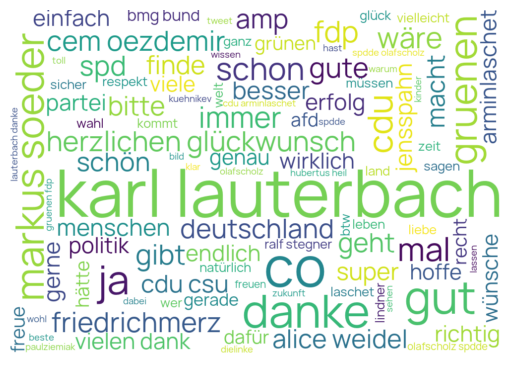

Word Cloud for Sentiment: 1


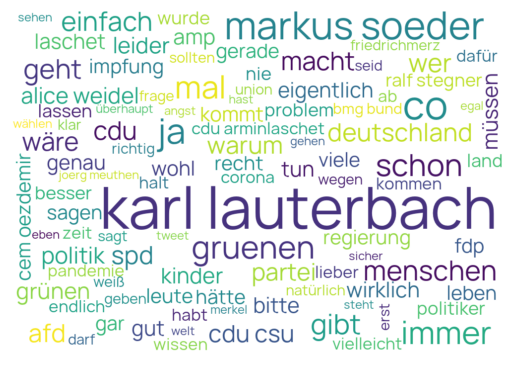

Word Cloud for Sentiment: 2


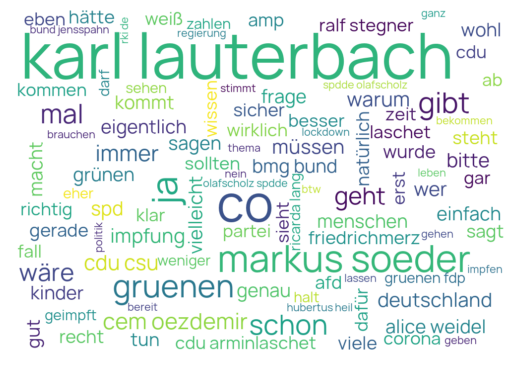

In [9]:
generate_wordclouds(df, "complete_dataset")